# Final Project Aviation Dataset

In [1]:
# Load Libraries here
import pandas as pd
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\16302/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\16302/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\16302/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Load Dataset

In [2]:
# Load the CSV (adjust path if needed)
df = pd.read_csv("data/ASRS_DBOnline.csv")

## Clean, Tokenize & Normalize

In [3]:
# 2.1 Drop any empty narratives
df = df.dropna(subset=['Report 1'])

# 2.2 Lower-case all text
df['clean_text'] = df['Report 1'].str.lower()

# 2.3 Remove everything except letters & spaces
df['clean_text'] = df['clean_text'].str.replace(r'[^a-z\s]', ' ', regex=True)

# 2.4 Tokenize by splitting on whitespace
df['tokens'] = df['clean_text'].str.split()

# 2.5 Remove stop words and 1-letter tokens
stop = set(stopwords.words('english'))
df['tokens'] = df['tokens'].apply(
    lambda toks: [t for t in toks if t not in stop and len(t) > 1]
)

# 2.6 Lemmatize for normalization
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['tokens'].apply(
    lambda toks: [lemmatizer.lemmatize(t) for t in toks]
)

In [4]:
df[['Report 1','clean_text','tokens']].head()

Report 1  \
0                                          Narrative   
1  Was told to line up and wait runway XXR at int...   
2  A large corporate aircraft taxied with in 5-8 ...   
3  GPS Spoofing. Enroute today from ZZZ to SOF; w...   
4  Practicing simulated arcs with instrument stud...   

                                          clean_text  \
0                                          narrative   
1  was told to line up and wait runway xxr at int...   
2  a large corporate aircraft taxied with in     ...   
3  gps spoofing  enroute today from zzz to sof  w...   
4  practicing simulated arcs with instrument stud...   

                                              tokens  
0                                        [narrative]  
1  [told, line, wait, runway, xxr, intersection, ...  
2  [large, corporate, aircraft, taxied, inch, sta...  
3  [gps, spoofing, enroute, today, zzz, sof, nort...  
4  [practicing, simulated, arc, instrument, stude...

## Exploratory Data Analysis

Assessments.1
Human Factors                               2055
Aircraft                                    1751
Weather                                      218
ATC Equipment / Nav Facility / Buildings      70
Environment - Non Weather Related             67
Staffing                                       2
Primary Problem                                1
Name: count, dtype: int64


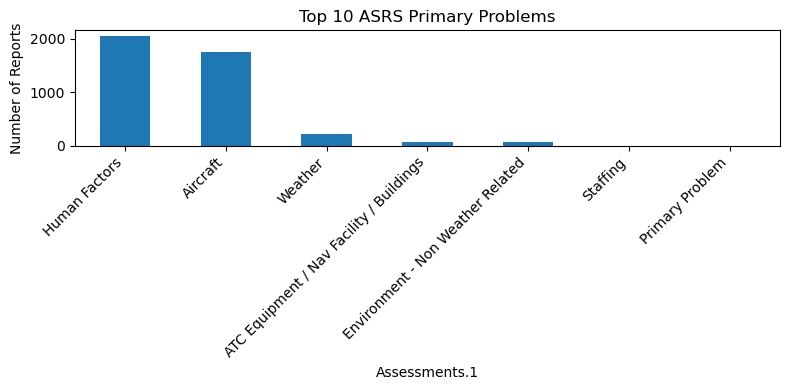

In [5]:
# Count how many reports per problem category
label_counts = df['Assessments.1'].value_counts()

# Display top 10
print(label_counts.head(10))

# Bar plot of top 10
label_counts.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 ASRS Primary Problems")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Human Factors and Aircraft account for nearly 90% of the reports.

count    4164.000000
mean      123.274015
std       104.814701
min         1.000000
25%        57.000000
50%        95.000000
75%       157.000000
max      1102.000000
Name: token_count, dtype: float64


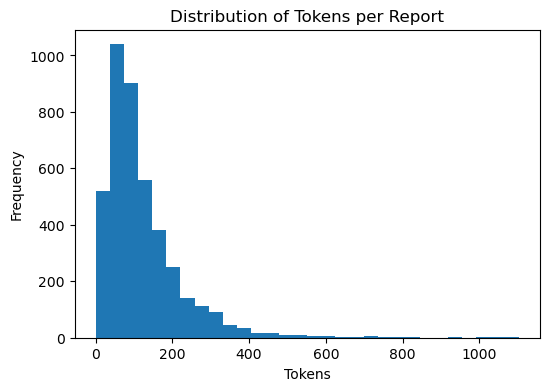

In [6]:
# Compute token counts
df['token_count'] = df['tokens'].map(len)

print(df['token_count'].describe())

df['token_count'].plot(kind='hist', bins=30, figsize=(6,4))
plt.title("Distribution of Tokens per Report")
plt.xlabel("Tokens")
plt.show()

Narratives average about 123 Tokens with a majority falling between 60 and 160 words. This makes sense as radio communications should be "short and sweet". 

             freq
aircraft     9395
zzz          6799
runway       5553
flight       5346
approach     3781
landing      3547
u            3482
engine       3459
time         2868
back         2814
pilot        2797
would        2519
left         2443
altitude     2413
right        2323
atc          2257
control      2187
airport      2084
captain      1932
maintenance  1905


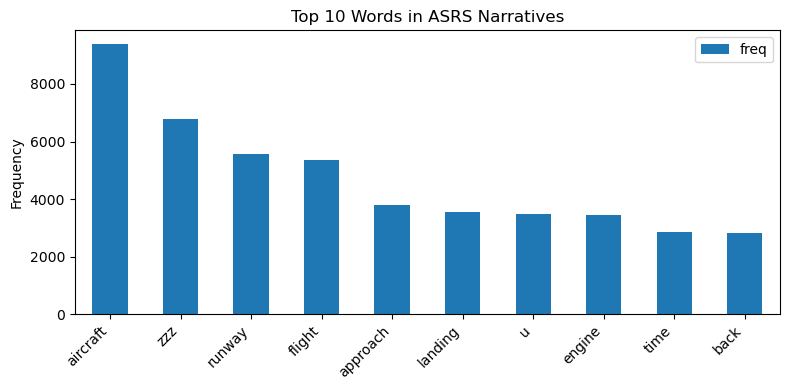

In [7]:
# Flatten all tokens into one list and count
all_counts = Counter()
df['tokens'].map(all_counts.update)

# Convert to DataFrame
freq_df = (
    pd.DataFrame.from_dict(all_counts, orient='index', columns=['freq'])
      .sort_values('freq', ascending=False)
)

# Show top 20
print(freq_df.head(20))

# Plot top 10
freq_df.head(10).plot(kind='bar', figsize=(8,4))
plt.title("Top 10 Words in ASRS Narratives")
plt.ylabel("Frequency")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

ZZZ suggests further cleaning. Aircraft, Runway, Flight, Approach reflect reports consisting of routine aircraft operations and runway interactions. 

## Create Features and Labels - 

Use preprocessed tokens to create features and use Assessments.1 as the label

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Join tokens back to string for vectorization
df['joined_tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

# Drop rare labels to avoid training issues (optional)
label_counts = df['Assessments.1'].value_counts()
top_labels = label_counts[label_counts > 20].index  # keep labels with >20 examples
filtered_df = df[df['Assessments.1'].isin(top_labels)]

X = filtered_df['joined_tokens']
y = filtered_df['Assessments.1']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)


## Train Classifier
Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_vec, y_train)

# Predict on test set
y_pred = clf.predict(X_test_vec)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8715486194477791

Classification Report:
                                           precision    recall  f1-score   support

ATC Equipment / Nav Facility / Buildings       0.25      0.07      0.11        14
                                Aircraft       0.88      0.90      0.89       351
       Environment - Non Weather Related       0.50      0.08      0.13        13
                           Human Factors       0.87      0.95      0.91       411
                                 Weather       0.95      0.43      0.59        44

                                accuracy                           0.87       833
                               macro avg       0.69      0.49      0.53       833
                            weighted avg       0.86      0.87      0.86       833



## Confusion Matrix

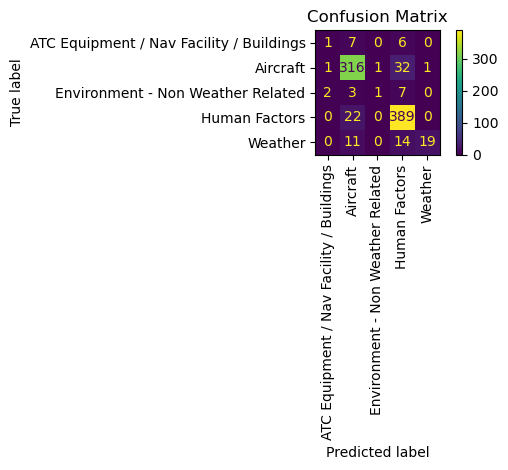

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(clf, X_test_vec, y_test, xticks_rotation='vertical')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

## Additional Classifiers
Random Forest

In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_vec, y_train)

y_pred_rf = rf.predict(X_test_vec)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, zero_division=0))


Random Forest Accuracy: 0.8559423769507803
                                          precision    recall  f1-score   support

ATC Equipment / Nav Facility / Buildings       0.00      0.00      0.00        14
                                Aircraft       0.84      0.92      0.88       351
       Environment - Non Weather Related       1.00      0.08      0.14        13
                           Human Factors       0.87      0.91      0.89       411
                                 Weather       0.93      0.32      0.47        44

                                accuracy                           0.86       833
                               macro avg       0.73      0.45      0.48       833
                            weighted avg       0.85      0.86      0.84       833



In [16]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
nb.fit(X_train_vec, y_train)

y_pred_nb = nb.predict(X_test_vec)
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb, zero_division=0))


Naive Bayes Accuracy: 0.8379351740696278
                                          precision    recall  f1-score   support

ATC Equipment / Nav Facility / Buildings       0.00      0.00      0.00        14
                                Aircraft       0.83      0.90      0.86       351
       Environment - Non Weather Related       0.00      0.00      0.00        13
                           Human Factors       0.84      0.93      0.89       411
                                 Weather       0.00      0.00      0.00        44

                                accuracy                           0.84       833
                               macro avg       0.33      0.37      0.35       833
                            weighted avg       0.77      0.84      0.80       833



In [17]:
from sklearn.svm import LinearSVC

svc = LinearSVC()
svc.fit(X_train_vec, y_train)

y_pred_svc = svc.predict(X_test_vec)
print("Linear SVC Accuracy:", accuracy_score(y_test, y_pred_svc))
print(classification_report(y_test, y_pred_svc))


Linear SVC Accuracy: 0.8811524609843937
                                          precision    recall  f1-score   support

ATC Equipment / Nav Facility / Buildings       0.38      0.21      0.27        14
                                Aircraft       0.89      0.91      0.90       351
       Environment - Non Weather Related       0.50      0.15      0.24        13
                           Human Factors       0.88      0.94      0.91       411
                                 Weather       0.96      0.55      0.70        44

                                accuracy                           0.88       833
                               macro avg       0.72      0.55      0.60       833
                            weighted avg       0.88      0.88      0.87       833



## Classification Summary

In [19]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import pandas as pd

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Naive Bayes": MultinomialNB(),
    "Linear SVC": LinearSVC()
}

# Collect metrics
results = []

for name, model in models.items():
    model.fit(X_train_vec, y_train)
    y_pred = model.predict(X_test_vec)

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "F1 Score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    })

# Create DataFrame
results_df = pd.DataFrame(results)

# Format & style
styled_df = (
    results_df.style
        .format({col: "{:.2%}" for col in results_df.columns if col != "Model"})
        .set_caption("📊 Classification Model Performance")
        .highlight_max(axis=0, subset=results_df.columns[1:], color='lightgreen')
        .highlight_min(axis=0, subset=results_df.columns[1:], color='lightcoral')
        .set_table_styles([
            {"selector": "caption", "props": [("text-align", "center"), ("font-size", "16px"), ("font-weight", "bold")]}
        ])
)

# Display
styled_df


Naive Bayes has the worst perfroming across the metrics as indicated by the lowest values.
Linear SVC is the best performing classifier.